# Ensamble de modelos
Construir dos ensambles de modelos de tipo híbridos:

In [2]:
#Librerías para manejo de datos
import numpy as np 
import pandas as pd
from collections import defaultdict

#Librerías para gráficos
import matplotlib.pyplot as plt
import seaborn as sns

#Librerias utilizadas en el Ensamble 1
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score


#Librerias utilizadas en el Ensamble 2
from sklearn.ensemble import StackingClassifier
from sklearn.cluster import KMeans
from sklearn.linear_model import RidgeCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegressionCV

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from collections import defaultdict

In [4]:
df = pd.read_csv("./work/properati_argentina_2021_tp1.csv")

# Quito variables indicativas del precio de venta
df.drop(['tipo_precio', 'pxm2'], axis=1, inplace=True)

# Transformo variables categoricas para poder utilizarlas como predictorias
df = pd.get_dummies(df, columns=["place_l3","property_type"], drop_first=True)

# Creo un dataset con los features que voy a usar para clasificar
x = df.drop(['property_price'], axis='columns', inplace=False)

#Creo un dataset con la variable target
y = df['property_price'].copy()

#Genero los conjuntos de train y test
x_train, x_test, y_train, y_test = train_test_split(x,y,
                                                    test_size=0.2,  #proporcion 80/20
                                                    random_state=2)

## Ensamble 1
Ensamble tipo Voting para el conjunto de datos de clasificación. Obtener sus métricas y comparar los resultados con los obtenidos en los puntos anteriores.

In [5]:
tree_clf = DecisionTreeClassifier(max_depth=5)
rnd_clf = RandomForestClassifier(max_depth=5)
knn_clf = KNeighborsClassifier(7)

voting_clf = VotingClassifier(estimators=[('rnd', rnd_clf), ('dt', tree_clf), ('knn', knn_clf)],
                              voting='hard')

voting_clf.fit(x_train, y_train)

VotingClassifier(estimators=[('rnd', RandomForestClassifier(max_depth=5)),
                             ('dt', DecisionTreeClassifier(max_depth=5)),
                             ('knn', KNeighborsClassifier(n_neighbors=7))])

Evaluo el conjunto de test

In [6]:
for clf in (rnd_clf, knn_clf, voting_clf):
    result = cross_val_score(clf, x, y, scoring='accuracy', cv=10)
    print(clf.__class__.__name__, result.mean())

/home/juan518/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


RandomForestClassifier 0.03291842237671834


/home/juan518/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


KNeighborsClassifier 0.036602869808250976


/home/juan518/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


VotingClassifier 0.030857986727045022


In [7]:
pred = voting_clf.predict(x_test)
accuracy_score(y_test, pred)

0.032602108835292694

## Ensamble 2
ensamble de tipo Stacking combinando diferentes modelos de regresión y utilizando un modelo adicional para estimar el valor final. Mostrar las métricas obtenidas y comparar con los resultados obtenidos en los puntos anteriores.

Defino una función para evaluar los modelos con 5fold cross validation

In [60]:
def evaluate_model(model, x, y):
    cv = RepeatedStratifiedKFold(n_splits=50, n_repeats=2, random_state=1)
    scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv, verbose=1, n_jobs=-1, error_score='raise')
    return scores

Defino otra función para plotear la accuracy de cada modelo

Analizo la performance de cada modelo base por separado y almaceno sus scores para compararlos posteriormente

In [61]:
base_models = {'random_forest':RandomForestClassifier(max_depth=12),
               'gnb': GaussianNB(),
               'knn': KNeighborsClassifier(n_neighbors=5)}

model_scores = defaultdict()

#Entreno los clasificadores
for name, model in base_models.items():
    print('Evaluating {}'.format(name))
    scores = evaluate_model(model, x_train, y_train)
    model_scores[name] = scores

Evaluating random_forest


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Evaluating gnb


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Evaluating knn


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.7s finished


Cambiamos el formateo de base_models para poder utilizarlo como parametro en la llamada a función del ensamble.

In [62]:
base_models = [('random_forest', RandomForestClassifier(max_depth=12)),
               ('gnb', GaussianNB()),
               ('knn', KNeighborsClassifier(n_neighbors=5))]

Utilizaremos como estimador final un modelo de regresión logística con cross validation

In [63]:
final_model= LogisticRegressionCV()

Formamo el ensamble con los estimadores base y final

In [64]:
stacking_model = StackingClassifier(estimators=base_models,
                                    final_estimator=final_model,
                                    passthrough=True,
                                    cv=5)

Evaluamos la performance en el conjunto de entrenamiento

In [65]:
ensemble_score = evaluate_model(stacking_model, x_train, y_train)
model_scores['ensemble'] = ensemble_score

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 32.8min finished


Grafico de accuracy para cada modelo por separado y el ensamble de stacking

In [66]:
for model, score in model_scores.items():
    print("Precision " + model + ":")
    print( str(round(score.mean()*100, 2)) + "%")

Precision random_forest:
62.01%
Precision gnb:
50.5%
Precision knn:
57.58%
Precision ensemble:
64.83%


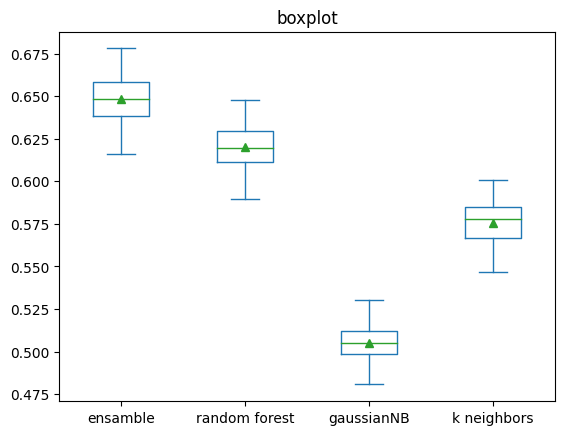

In [67]:
data = pd.DataFrame({'ensamble' : model_scores['ensemble'],
                     'random forest' : model_scores['random_forest'],
                     'gaussianNB' : model_scores['gnb'],
                     'k neighbors' : model_scores['knn']})

ax = data[['ensamble', 'random forest', 'gaussianNB', 'k neighbors']].plot(kind='box', title='boxplot', showmeans=True)

Evaluamos la accuracy en el conjunto de validación

In [68]:
stacking_model.fit(x_train,y_train)
y_pred_st = stacking_model.predict(x_test)
accuracy_score(y_test, y_pred_st)

C:\Users\Juan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\Juan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please

0.6512543934068598

Obtuvimos una accuracy similar al conjunto de entrenamiento.